<a href="https://colab.research.google.com/github/luimui/SS24-ExplainableAI/blob/main/11_notebook_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Model training

We train a logistic regression classifier on the handwritten digits datasets.
We modify the dataset slightly by changing it to a binary classification problem: all digits below 5 belong to one class, the rest to another.
The code is based on https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html.

If you run the cell, you should see that the model performs quite well with 86% accuracy.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for classifier LogisticRegression(max_iter=2000, penalty='none', random_state=0):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       448
           1       0.85      0.88      0.86       451

    accuracy                           0.86       899
   macro avg       0.86      0.86      0.86       899
weighted avg       0.86      0.86      0.86       899




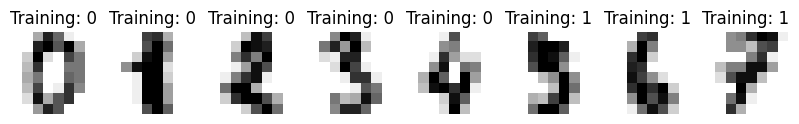

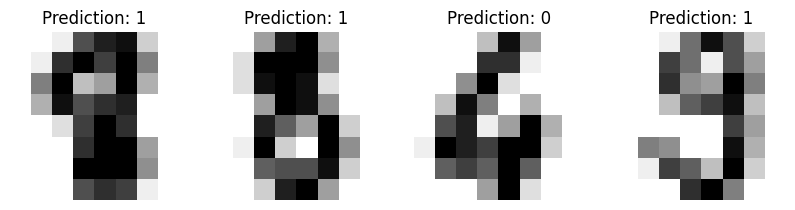

In [3]:
digits = datasets.load_digits()
digits.target = (digits.target >= 5).astype(int)  # modification into binary classification
_, axes = plt.subplots(nrows=1, ncols=8, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier
clf = LogisticRegression(random_state=0, max_iter=2000, penalty="none")

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, shuffle=False)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


## Fast Gradient Sign Method

Given the gradient that you calculated (Task 1.1 on the pdf), implement the FSGM method in the following function.
Use the fact that the gradient of the loss function (cross entropy) with respect to the input is:
\begin{equation}
\nabla_x \mathcal{L}(x,y,w) = \left(\frac{1 - y}{1 - \hat{y}} - \frac{y}{\hat{y}}\right) \nabla_x \hat{y},
\end{equation}
where $\hat{y} = \sigma(x,w)$ is short for the logistic sigmoid function.

In [ ]:
def grad_x_sigmoid(x: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    # TODO: implement the gradient of the sigmoid function wrt input x
    numerator     = -w.T @ np.exp(-w.T @ x)
    denominator   = (1 + np.exp(-2 * w.T @ x))^2

    return numerator / denominator

def sigmoid(x: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    """Logistic sigmoid function. Can be used as a helper function

    Args:
        x (np.ndarray): input features
        w (np.ndarray): weights
        b (float): bias

    Returns:
        np.ndarray: logistic sigmoid(w.T @ x)
    """
    # clip inputs to exp to avoid numerical problems
    return 1 / (1 + np.exp(-np.clip(w.T @ x - b, -50, 50)))


def grad_x_CEloss(x: np.ndarray, y: int, w: np.ndarray, b: float) -> np.ndarray:
    eps = 1e-5  # add a small constant in denominator to avoid division by zero
    # TODO: implement the gradient of the cross entropy loss with respect to x
    pred = sigmoid(x, w, b)
    return ((1-y)/(1-(pred + eps)) - y/(pred + eps)) * grad_x_sigmoid


def fgsm_example(x: np.ndarray, y: int, clf, eps: float = 0.1) -> np.ndarray:
    """Generate an adversarial example with FGSM

    Args:
        x (np.ndarray): input data point
        y (int): binary class label
        clf: sklearn logistic regression model
        eps (float, optional): Allowed perturbation. Defaults to 0.1.

    Returns:
        np.ndarray: perturbed image, same shape as x
    """
    # TODO (use the clf.coef_ and clf.intercept_ to get the weights)



Test your implementation in the following cell with different levels of perturbation `eps`.
It gives you a performance summary of the model on the original data and the perturbed data as well as visualizations of the original and perturbed images.
* Can you make out the difference between original and perturbed image?
* At what level of perturbation does the performance really start to decrease?


In [ ]:
def report(clf, X_test_orig, X_test_perturbed):
    predicted = clf.predict(X_test_orig)
    predicted_perturbed = clf.predict(X_test_perturbed)

    print(
        f"Classification report for classifier {clf} with original input:\n"
        f"{metrics.classification_report(y_test, predicted)}\n"
    )
    print(
        f"Classification report for classifier {clf} with perturbed inputs:\n"
        f"{metrics.classification_report(y_test, predicted_perturbed)}\n"
    )

    diffs = predicted != predicted_perturbed
    print(f"{diffs.sum()} out of {len(diffs)} differently predicted data points")

    n_cols = 5  # the number of predictions shown
    _, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(n_cols * 2.2, 3))
    for j, image_orig, image_pert, pred_orig, pred_perturbed in zip(
        range(n_cols),
        X_test_orig[diffs],
        X_test_perturbed[diffs],
        predicted[diffs],
        predicted_perturbed[diffs],
    ):
        axes[0, j].set_axis_off()
        axes[1, j].set_axis_off()
        image_orig = image_orig.reshape(8, 8)
        image_pert = image_pert.reshape(8, 8)
        axes[0, j].imshow(image_orig, cmap=plt.cm.gray_r, interpolation="nearest")
        axes[1, j].imshow(image_pert, cmap=plt.cm.gray_r, interpolation="nearest")
        axes[0, j].set_title(f"Pred (original): {pred_orig}")
        axes[1, j].set_title(f"Pred (perturbed): {pred_perturbed}")


# TODO
eps = 0.2  # allowed change per pixel
X_test_perturbed = np.array([fgsm_example(x, y, clf, eps=eps) for x, y in zip(X_test, y_test)])
report(clf, X_test, X_test_perturbed)


## Adverserial Training

Install `tqdm`, a package for progress bars, and `ipywidgets` in your environment:
```shell
conda activate xai
conda install tqdm ipywidgets
```

Afterwards, restart the notebook kernel and execute all cells again.



In [ ]:
from tqdm.notebook import tqdm

The following cell implements and trains a logistic regression model.
For a robust model that is not easily fooled by perturbed images, we want to solve the following problem:
\begin{equation}
\min_w \sum_{x,y} \max_{\delta \in N} f_w(x + \delta, y),
\end{equation}
where $N$ are the allowed perturbations.

**Your task is to implement adversarial training to create a model robust to FGSM.**
To do this, add code in the following cell marked with TODO. In the class, you only have to modify `fit_fgsm_robust`.

Train a standard model and a robust model and compare their performance on FGSM perturbed data.


In [ ]:
class LogisticClassifier:
    def __init__(self) -> None:
        self.w = None

    @property
    def coef_(self):
        return self.w[:-1]

    @property
    def intercept_(self):
        # print(self.w[-1], np.asarray(self.w[-1]).reshape(-1,))
        return np.asarray(self.w[-1]).reshape(-1,)

    def _add_constant(self, X: np.ndarray) -> np.ndarray:
        """Add a constant column to a matrix.

        Args:
            X (np.ndarray): Original data matrix

        Returns:
            np.ndarray: Original data matrix with concatenated column of all ones.
        """
        return np.hstack((X, np.ones((len(X), 1))))

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        learning_rate: float = 1e-4,
        n_epochs: int = 500,
        random_state: int = 42,
    ) -> None:
        """Fit the parameters of the model to the data with gradient descent.

        Args:
            X (np.ndarray): features
            y (np.ndarray): targets
            learning_rate (float): step size of gradient descent
            n_epochs (int): number of parameter updates
            random_state (int): seed for reproducibility
        """
        # initialize randomly
        rng = np.random.default_rng(random_state)
        self.w = rng.standard_normal(size=(X.shape[1] + 1,))  # +1 for bias
        # print(self.w.shape)

        # gradient descent
        for _ in tqdm(range(n_epochs)):
            self.w = self.w - learning_rate * self._gradient(X, y)
            if np.isnan(self.w).sum() > 0:
                raise ValueError("Weights have diverged", self.w)

    def fit_fgsm_robust(
        self,
        X: np.ndarray,
        y: np.ndarray,
        learning_rate: float = 1e-4,
        n_epochs: int = 500,
        random_state: int = 42,
        perturbation_eps: float = 0.5,
    ) -> None:
        """Fit the parameters of the model to FGSM-perturbed data with gradient descent.

        Args:
            X (np.ndarray): features
            y (np.ndarray): targets
            learning_rate (float): step size of gradient descent
            n_epochs (int): number of parameter updates
            random_state (int): seed for reproducibility
            perturbation_eps (float): level of allowed perturbation
        """
        # initialize randomly
        rng = np.random.default_rng(random_state)
        self.w = rng.standard_normal(size=(X.shape[1] + 1,))  # +1 for bias
        # print(self.w.shape)

        # gradient descent
        for _ in tqdm(range(n_epochs)):
            # TODO: implement the maximization step of the formula in the cell above

            if np.isnan(self.w).sum() > 0:
                raise ValueError("Weights have diverged", self.w)

    def _gradient(self, X: np.ndarray, y: np.ndarray):
        grad = sum(
            [
                (yhat - y) * x
                for x, y, yhat in zip(self._add_constant(X), y, self.predict_proba(X))
            ]
        )
        return grad

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Use parameters to predict values

        Args:
            X (np.ndarray): features

        Returns:
            np.ndarray: predicted probablities
        """
        X = self._add_constant(X)
        probas = []
        for x in X:
            probas.append(1 / (1 + np.exp(-self.w.T @ x)))
        probas = np.array(probas)
        return probas

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Use parameters to predict values (hard predictions)

        Args:
            X (np.ndarray): features

        Returns:
            np.ndarray: predicted class
        """
        threshold = 0.5
        X = self._add_constant(X)
        probas = []
        for x in X:
            probas.append(1 / (1 + np.exp(-self.w.T @ x)))
        probas = np.array(probas)
        return (probas > threshold).astype(int)


In [ ]:
# TODO: add training of a standard and a robust model
clf = ...
clf_robust = ...

Output for standard classifier

In [ ]:
eps = 0.6  # allowed change per pixel
X_test_perturbed = np.array([fgsm_example(x, y, clf, eps=eps) for x, y in zip(X_test, y_test)])
predicted_perturbed = clf.predict(X_test_perturbed)
report(clf, X_test, X_test_perturbed)

Output for robust classifier

In [ ]:
eps = 0.6  # allowed change per pixel
X_test_perturbed = np.array([fgsm_example(x, y, clf_robust, eps=eps) for (x, y) in zip(X_test, y_test)])
predicted_perturbed = clf_robust.predict(X_test_perturbed)
report(clf_robust, X_test, X_test_perturbed)

## Projection based gradient descent

Now, we implement a different adversarial attack, projection based gradient descent (PGD).
While FGSM only takes a single step, PGD takes many smaller steps and always projects updates back into the $l_\infty$ $\varepsilon$-neighborhood of x by clipping the updates.

* Add the code at the TODO. (Hint: You can reuse much of the code from before.)
* How does the adversarially robust classifier perform on the PGD data?

Solution: When correctly specifying the PGD attack, the robust model is barely better than the standard model.

In [ ]:
def pgd_example(
    x: np.ndarray,
    y: int,
    clf,
    eps: float = 0.4,
    n_steps: int = 10,
    step_size: float = 0.1,
) -> np.ndarray:
    """Generate an adversarial example with projected gradient descent (PGD)

    Args:
        x (np.ndarray): input data point
        y (int): binary target label
        clf: sklearn logistic regression model
        eps (float, optional): Allowed perturbation. Defaults to 0.4.
        n_steps (int, optional): Number of gradient descent steps. Defaults to 10.
        step_size(float, optional): Step size. Defaults to 0.1

    Returns:
        np.ndarray: perturbed image, same shape as x
    """
    # TODO (use the clf.coef_ to get the weights)



eps = 0.4  # allowed change per pixel
X_test_perturbed = np.array(
    [
        pgd_example(x, y, clf_robust, eps=eps, n_steps=10, step_size=0.05)
        for x, y in zip(X_test, y_test)
    ]
)
report(clf_robust, X_test, X_test_perturbed)


Analyze how the robust and standard classifier perform for PGD and FGSM attacks on various levels of epsilon by creating a plot that shows values of epsilon on the x-axis and accuracy of the classifier on the y-axis.

What can you observe for the robust classifier and FGSM attacks?

Solution: As noted before the robust classifier performs barely better than the standard model for PGD. For FGSM, the robust model performs worse than the standard model on clean data. It is overfit on FGSM data.

In [ ]:
# TODO: PGD


In [ ]:
# TODO: FGSM
